<a href="https://colab.research.google.com/github/justingardner/tutorials/blob/master/population.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Learning goals for the FrequencyFreaks notebook. After working through this notebook you will be able to...
  * show that a directional derivative of an image is a ramp in the frequency domain

In [72]:
# Import libraries that we need
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import matplotlib.image as image
import imageio as iio
from scipy import interpolate
import scipy.stats as stats
import scipy.signal as signal
from tqdm import tqdm as progressBar

Let's start by importing some of the functions from the frequency freaks notebook.

In [2]:
def getMeshPoints(nPoints):

  # first create a linearly spaced set of x and y points between -1 and 1
  x = np.linspace(-1,1,nPoints)
  y = np.linspace(-1,1,nPoints)

  # keep the extents for use with imshow
  extents = [np.min(x),np.max(x),np.min(y),np.max(y)]

  # now create the mesh of x and y (these will now both be 2D matrices of x and y values)
  x, y = np.meshgrid(x, y, indexing='xy')

  # and return the computed values
  return x, y, extents
def getImage(filename,imageSize):
  # first load the image
  img = iio.imread(filename)

  # make graycale by averaging across color dimensions
  img = img.mean(2)

  # get a square of the image
  imgSquareSize = np.min(img.shape);
  img =img[0:imgSquareSize,0:imgSquareSize]

  # interpolate to preferred size 
  fun = interpolate.interp2d(np.linspace(0,1,imgSquareSize),np.linspace(0,1,imgSquareSize),img,kind='linear')
  img = fun(np.linspace(0,1,imageSize),np.linspace(0,1,imageSize))

  # normalize values to between -1 and 1
  # just because this is a typical and easy way to 
  # think about values of an image 0 is gray -1 is black and 1 is white
  # just like for a sinewave grating!
  img = (img - img.min())/(img.max() - img.min())
  img = 2 * img - 1

  # return the image
  return img 

# save a grayscale image
def mysave(saveName,img):
  saveImage = (img-np.min(img))/(np.max(img)-np.min(img))
  saveImage = np.repeat(saveImage[:, :, np.newaxis], 3, axis=2)
  image.imsave(saveName,saveImage)
  
def makeGaussian(x,y,sigma):
  # there it is!
  gaussian = np.exp(-(x**2+y**2)/(2*sigma**2))
  
  # return 
  return gaussian

def makeGrating(x, y, orientation,spatialFrequency):
  # we wil convert orientation into radians
  orientation = np.pi*orientation/180

  # we need to convert spatial frequency into cycles/image
  # remember that we made the extents in getMeshPoints
  # to go from -1 to 1, so we want that to go from -pi to pi
  spatialFrequency = spatialFrequency * np.pi

  # make the grating
  grating = np.cos(spatialFrequency*(x*np.cos(orientation)+y*np.sin(orientation)))

  # and return
  return grating



Now, let's try to load an image. Take an image from anywhere and load into the files tab to the left (png format works so you can use a screen capture if you are on a mac). All you have to do is click on the folder icon at the left near the top and you should see a directory with "sample_data" as one of the folders. Just drag and drop your image over there (i.e. underneath "sample_data", not in the sample_data directory though - below the directory), and then you should be good to go. I'm moving an image called brain_both.png. You will need to change the filename below to make it point to your image.

64

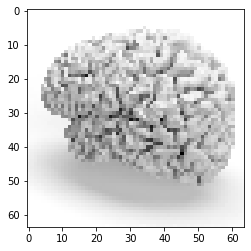

In [248]:
n = 64
x, y, extents = getMeshPoints(n)
# load the image
img = getImage("brain_both.png",n)

# and display
plt.imshow(img,cmap='gray')
np.size(img,1)

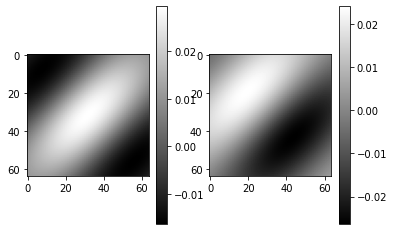

In [249]:
# Equation 17 is the "mother function" gabor wavelet. i.e. all the gabor wavelets
# can be created by either dilating this function (making it smaller or larger) and
# and rotating it. That kappa parameter is the spatial frequency bandwidth. Set 
# to pi for bandwidth of one octave and 2.5 for a bandwidth of 1.5 (see text
# after equation 3)
def psi(x, y, kappa, theta, dilation, phase):
  # rotate the coordinates according to theta
  xr = x * np.cos(theta) + y * np.sin(theta)
  yr = -x * np.sin(theta) + y * np.cos(theta)
  # dilate the coordinates (not sure what they are supposed to be
  # according to the paper, the scalar in here shifts that
  # 1 is -1 to 1 and 2 is -2 to 2, etc
  scaleFactor = 1;
  x = (2**dilation)*scaleFactor*xr; y = (2**dilation)*scaleFactor*yr;
  # gaussian window function, for settings as in the paper
  # this should be elongated, in that case set sigmay = 8
  sigmax = 2; sigmay = 2;
  gaussWindow = (1/np.sqrt(2*np.pi)) * np.exp(-(x**2/sigmax + y**2/sigmay))
  # make grating, this uses a complex exponential (just to be a bit tricky)
  # which basically just turns into a sinusoid, remember that
  # e**(-i*x) = cos(x) + i sin(x) - which can be easily
  # proven by using Taylor series expansions.
  grating = np.exp(kappa*complex(0,1)*x+complex(0,1)*phase)-np.exp(-(kappa**2)/2)
  # now we have the grating of the right spatial frequency
  # just multipy by the gaussian window
  wavelet = np.real(gaussWindow*grating)
  # normalize so that dot product is 1
  norm = np.dot(wavelet.flatten(),wavelet.flatten());
  wavelet = wavelet / np.sqrt(norm);
  # return the wavelet
  return wavelet

kappa = 2.5;
theta = np.pi/4;
dilation = 0;
phase1 = 0;
phase2 = np.pi/2;

g1 = psi(x,y,kappa,theta,dilation,phase1)
g2 = psi(x,y,kappa,theta,dilation,phase2)

plt.subplot(1,2,1)
plt.imshow(g1,cmap='gray')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(g2,cmap='gray')
plt.colorbar()


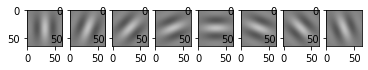

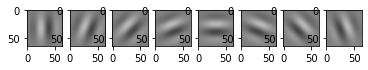

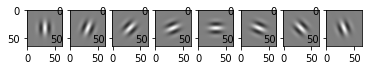

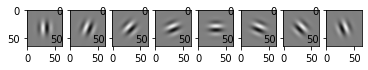

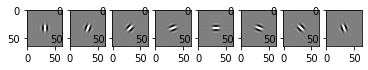

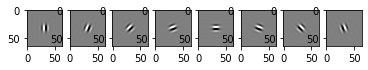

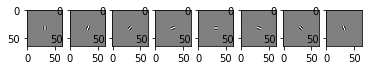

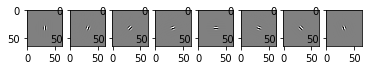

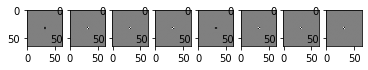

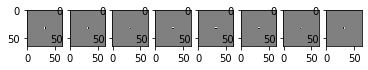

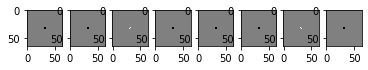

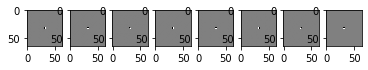

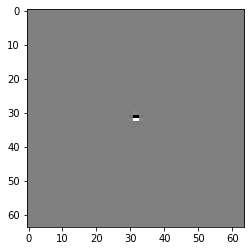

In [250]:
# create the gabor wavelet
# M is the number of layers, N is the number of frequency steps
# and k is the number of orientations
def createGaborWavelet(x,y,M,k,N,kappa):
  gaborWavelet = [[[[0 for x in range(2)] for x in range(N)] for x in range(k)] for x in range(M)]
  for iDilation in range(0,M):
    for iOrientation in range(0,k):
      for iFrequencyStep in range(0,N):
        for iPhase in range(0,2):
          gaborWavelet[iDilation][iOrientation][iFrequencyStep][iPhase] = psi(x,y,kappa,np.pi*iOrientation/k,2**(-(N-1-iFrequencyStep)/N)+iDilation,iPhase*np.pi/2)
  return gaborWavelet, (x,y,M,k,N,kappa)

# number of orientations
k = 8
# number of frequency steps
N = 1
# kappa sets the bandwidth. Set np.pi for 1, 2.5 is 1.5 
kappa = np.pi;
# number of dilations
M = 6;

gaborWavelet, params = createGaborWavelet(x,y,M,k,N,kappa)

#display
for iDilation in range(0,M):
  for iFrequencyStep in range(0,N):
    for iPhase in range(0,2):
      plt.figure();
      for iOrientation in range(0,k):
        plt.subplot(1,k,iOrientation+1);
        plt.imshow(gaborWavelet[iDilation][iOrientation][iFrequencyStep][iPhase],cmap='gray',vmin=-0.1,vmax=0.1)

# show the smallest filter
plt.figure()
plt.imshow(gaborWavelet[iDilation][iOrientation][iFrequencyStep][iPhase],cmap='gray',vmin=-0.1,vmax=0.1)

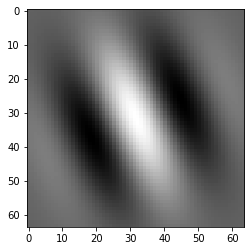

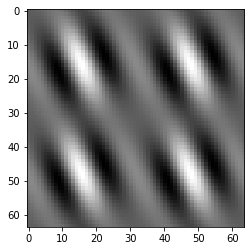

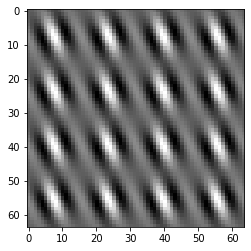

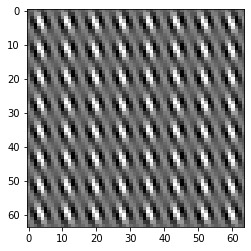

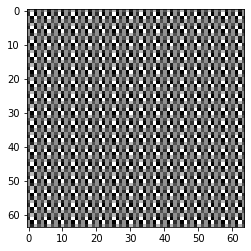

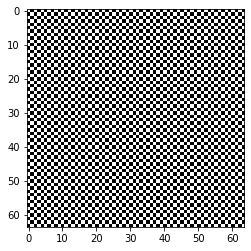

In [251]:
# get all the shifts needed for each level of the pyramid. Note 
# that a full convolution is not done (the steerable pyramid
# does a full convolution, but saves coefficients by downsampling
# each layer of the pyramid. Here, the bo tells the stride. If 
# set to 1, it will make the filters tile for that layer, i.e.
# the 2nd layer will have 2x2 filters. If set to smaller, then
# the stride will be that fraction i.e. bo=0.8 (as used in the
# paper, will place a filter every 0.8 instead of every 1)
def getShiftedWavelets(gaborWavelet,thisDilation,thisOrientation,thisFrequencyStep,thisPhase,bo):
  # get the wavelet
  wavelet = gaborWavelet[thisDilation][thisOrientation][thisFrequencyStep][thisPhase]
  # get size of wavelet
  n = np.size(wavelet,0)
  # compute how many phases we have (phase means positions)
  nXPhase = int(np.round((2**thisDilation)/bo));
  nYPhase = int(np.round((2**thisDilation)/bo));
  # get an apporiately sized list
  shiftedWavelets = [[0 for x in range(nXPhase)] for x in range(nYPhase)]
  # now for each possible position
  for iXPhase in range(0,nXPhase):
    # Get the X shift
    if (thisDilation > 0):
      shiftXPixels = int(-n/(2**(thisDilation+1))+iXPhase*n/nXPhase)
    else:
      shiftXPixels = iXPhase*n/nXPhase
    # now for each yphase
    for iYPhase in range(0,nYPhase):
      # get the y shift
      if (thisDilation > 0):
        shiftYPixels = int(-n/(2**(thisDilation+1))+iYPhase*n/nYPhase)
      else:
        shiftYPixels = iYPhase*n/nYPhase
      # and shift the wavelet appropriately
      shiftedWavelets[iXPhase][iYPhase] = np.roll(wavelet,shiftXPixels,axis=0)
      shiftedWavelets[iXPhase][iYPhase] = np.roll(shiftedWavelets[iXPhase][iYPhase],shiftYPixels,axis=1)
  # return the list of shifted wavelets
  return shiftedWavelets

bo = 1;
M = 6;
k = 8;
N = 3;
n = np.size(img,0)
gaborWavelet, params = createGaborWavelet(x,y,M,k,N,kappa)

# get all the wavelets at this level of the pyramid
for iDilation in range(0,M):
  shiftedWavelets = getShiftedWavelets(gaborWavelet,iDilation,7,2,0,bo)
  # and draw all into one to check
  totalWavelet = np.zeros((n,n));
  # start new figure
  plt.figure()
  # for each x phase
  for iXPhase in range(0,np.size(shiftedWavelets,0)):
    # now for each yphase
    for iYPhase in range(0,np.size(shiftedWavelets,1)):
      # sum the wavelet into the total one
      totalWavelet = totalWavelet + shiftedWavelets[iXPhase][iYPhase]
  # display
  plt.imshow(totalWavelet,cmap='gray')



Encoding image in dilation 1/6 of gabor wavelet pyramid: 100%|██████████| 24/24 [00:00<00:00, 3465.41it/s]
Encoding image in dilation 2/6 of gabor wavelet pyramid: 100%|██████████| 24/24 [00:00<00:00, 1328.31it/s]
Encoding image in dilation 3/6 of gabor wavelet pyramid: 100%|██████████| 24/24 [00:00<00:00, 286.16it/s]
Encoding image in dilation 4/6 of gabor wavelet pyramid: 100%|██████████| 24/24 [00:00<00:00, 111.11it/s]
Encoding image in dilation 5/6 of gabor wavelet pyramid: 100%|██████████| 24/24 [00:01<00:00, 18.60it/s]
Encoding image in dilation 6/6 of gabor wavelet pyramid: 100%|██████████| 24/24 [00:11<00:00,  2.10it/s]


Encoding used 65520 coefficients


Decoding image in dilation 1/6 of gabor wavelet pyramid: 100%|██████████| 24/24 [00:00<00:00, 2450.06it/s]
Decoding image in dilation 2/6 of gabor wavelet pyramid: 100%|██████████| 24/24 [00:00<00:00, 1598.29it/s]
Decoding image in dilation 3/6 of gabor wavelet pyramid: 100%|██████████| 24/24 [00:00<00:00, 473.36it/s]
Decoding image in dilation 4/6 of gabor wavelet pyramid: 100%|██████████| 24/24 [00:00<00:00, 116.92it/s]
Decoding image in dilation 5/6 of gabor wavelet pyramid: 100%|██████████| 24/24 [00:01<00:00, 19.15it/s]
Decoding image in dilation 6/6 of gabor wavelet pyramid: 100%|██████████| 24/24 [00:06<00:00,  3.54it/s]


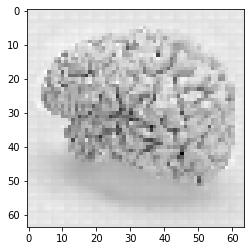

In [253]:
def encodeImage(img,gaborWavelet,params,bo):
  # get parameters
  M = params[2]
  k = params[3]
  N = params[4]
  nCoefficients = 0;
  # init encoding list
  encoding = [[[[0 for x in range(2)] for x in range(N)] for x in range(k)] for x in range(M)]
  # get encoding
  for iDilation in range(0,M):
    for iOrientation in progressBar(range(0,k),'Encoding image in dilation %i/%i of gabor wavelet pyramid'%(iDilation+1,M)):
      for iFrequencyStep in range(0,N):
        for iPhase in range(0,2):
          # get all the shifted filters
          shiftedWavelets = getShiftedWavelets(gaborWavelet,iDilation,iOrientation,iFrequencyStep,iPhase,bo);
          # get how many phases there are
          nXPhase = np.size(shiftedWavelets,0);
          nYPhase = np.size(shiftedWavelets,1);
          # and create an output list
          waveletProjection = np.zeros((nXPhase,nYPhase));
          # for each x phase
          for iXPhase in range(0,nXPhase):
            # now for each yphase
            for iYPhase in range(0,nYPhase):
              # get this wavelets projection
              waveletProjection[iXPhase,iYPhase] = np.dot(img.flatten(),shiftedWavelets[iXPhase][iYPhase].flatten());
              # count number of coefficients
              nCoefficients += 1;
          # stick into the encoding list
          encoding[iDilation][iOrientation][iFrequencyStep][iPhase] = waveletProjection;
  # print how many coefficients
  print('Encoding used %i coefficients'%(nCoefficients))
  # return the encoding
  return encoding

def decodeImage(encoding,gaborWavelet,params,bo):
  # get paramters
  M = params[2]
  k = params[3]
  N = params[4]
  n = np.size(params[0],0)
  # init image
  img = np.zeros((n,n));
  # create image from encoding
  for iDilation in range(0,M):
    for iOrientation in progressBar(range(0,k),'Decoding image in dilation %i/%i of gabor wavelet pyramid'%(iDilation+1,M)):
      for iFrequencyStep in range(0,N):
        for iPhase in range(0,2):
          # get all the shifted filters
          shiftedWavelets = getShiftedWavelets(gaborWavelet,iDilation,iOrientation,iFrequencyStep,iPhase,bo)
          # get how many phases there are
          nXPhase = np.size(shiftedWavelets,0);
          nYPhase = np.size(shiftedWavelets,1);
          # for each x phase
          for iXPhase in range(0,nXPhase):
            # now for each yphase
            for iYPhase in range(0,nYPhase):
              # sum the wavelet into the total one
              img = img + encoding[iDilation][iOrientation][iFrequencyStep][iPhase][iXPhase][iYPhase] * shiftedWavelets[iXPhase][iYPhase];
  # return the encoding
  return img

# parameters
M = 6;
k = 24;
N = 1;
kappa = np.pi;
bo = 1;

# encode an image in a gabor wavelet pyramid
gaborWavelet, params = createGaborWavelet(x,y,M,k,N,kappa)
encoding = encodeImage(img,gaborWavelet,params,bo);
# and recreate it from the coefficients
decodedImg = decodeImage(encoding,gaborWavelet,params,bo)
# show the reconstructed image
plt.imshow(decodedImg,cmap='gray')


Alright. Let's get right to it. What does the Fourier transform of this image look like? We will plot the magnitude spectrum which shows the amplitude of each of the sinusoidal gratings that make up an image.

In [ ]:
# take Fourier transform
imgFFT = np.fft.fft2(img)

# now we will shift the image so that the middle will
# be the DC (luminance) component (otherwise, it plots
# in a way that is not as intuitive to understand)
imgFFT = np.fft.fftshift(imgFFT)

def displayMagSpectrum(imgFFT):
  # get center line
  centerLine = int(np.round(np.size(imgFFT,1)/2))

  # Display the amplitude spectrum by taking the magnitude
  # of the fourier transform (note that due to technical reasons
  # in how the FFT is computed - with complex exponentials - the
  # values of the FFT are complex numbers where the magnitude 
  # relfects the weight of the sinusoidal component and the phase
  # of the number represents the phase of the sinusoidal component
  # needed)
  imgMag = np.abs(imgFFT)

  # The image spectrum is typicall really hard to see when
  # plotted directly because the DC value is really large
  # compared to other values, and so the scaling in imshow
  # makes it look like one big black square with a bright
  # point at the very center. To make it easier to see,
  # we normalize the values between 0 and 1 and then
  # we are going to pump it through a function that boosts
  # up small values to make the image more visible. Not
  # really important what this function is, but for your 
  # reference, I'm using 1 - exponential function
  imgMagNormalized = (imgMag - imgMag.min())/(imgMag.max()-imgMag.min())
  imgMagAdjusted = (1-np.exp(-imgMagNormalized**0.1))/(1-np.exp(-1))

  # display
  plt.subplot(1,3,1)
  plt.imshow(imgMagAdjusted,cmap='gray',extent=extents)
  plt.subplot(1,3,2)
  plt.plot(imgMag[:,centerLine])
  plt.xlabel('Frequency component')
  plt.ylabel('Magnitude')
  plt.subplot(1,3,3)
  plt.plot(imgMag[centerLine,:])


32


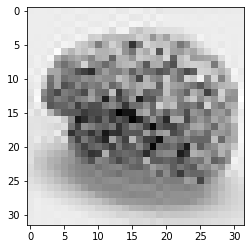

In [ ]:
# down sample function
def downSample(img):
  # get size
  n = np.size(img,1)
 
  # take Fourier transform and shift components so that dc is in the center
  imgFFT = np.fft.fftshift(np.fft.fft2(img))

  # now get where the dc component is
  dc = n/2
 
  # and keep only half the frequencies around
  # that component. Note that means that we take
  # n/4 becase there are n/2 frequencies in the 
  # image (the other n/2 are the "negative" frequencies)
  halfComponents = n/4

  negBound = int(np.floor(dc-halfComponents))
  posBound = int(np.ceil(dc+halfComponents))
  imgDownSampledFFT = imgFFT[negBound:posBound,negBound:posBound]

  # take the inverse transform (and just get the real part)
  imgDownSampled = np.real(np.fft.ifft2(np.fft.fftshift(imgDownSampledFFT)))

  # and return
  return(imgDownSampled)

imgDownSampled = downSample(img)
plt.imshow(imgDownSampled,cmap='gray')
print(np.size(imgDownSampled,1))


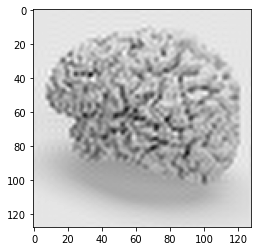

In [ ]:
# down sample function
def upSample(img):

  # get size
  n = np.size(img,1)
 
  # take Fourier transform and shift components so that dc is in the center
  imgFFT = np.fft.fftshift(np.fft.fft2(img))

  # create an array of zeros that is twice as large as the original
  # make sure that the type is complex to hold the complex spectrum values
  imgUpSampledFFT = np.zeros((n*2,n*2),dtype='complex')

  # and set the center frequencies of this larger image
  # to be imgFFT. What we are doing here is known as "zero padding"
  # as we are putting zeros into the higher spatial frequencies
  # This will make an image that is twice as big as the original
  # when we inverse transform back. Which means that it is interpolating
  # the original image. What function is it interpolating with? Well
  # if you think in the frequency domain, the effect of the zeros is
  # that you are essentially multiplying the transform by a square function
  # with ones in the middle and zeros on the outside. In the image
  # domain this is a sinc function, which is convolved with the image.
  dc = n
  halfComponents = n/2
  negBound = int(np.round(dc-halfComponents))
  posBound = int(np.round(dc+halfComponents))
  imgUpSampledFFT[negBound:posBound,negBound:posBound] = imgFFT

  # take the inverse transform (and just get the real part)
  imgUpSampled = np.real(np.fft.ifft2(np.fft.fftshift(imgUpSampledFFT)))

  # and return
  return(imgUpSampled)

imgUpSampled = upSample(img)
plt.imshow(imgUpSampled,cmap='gray');
mysave('upsample.png',imgUpSampled)

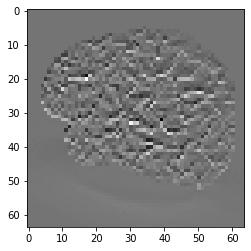

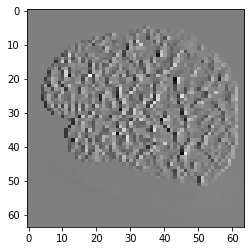

In [ ]:
# take a directional derivative of an image

# get size
n = np.size(img,1)
imgDeriv = img[1:,:]-img[0:-1,:]
imgDeriv = np.insert(imgDeriv,0,0,axis=0)
plt.imshow(imgDeriv,cmap='gray')
plt.figure()
imgDeriv = img[:,1:]-img[:,0:-1]
imgDeriv = np.insert(imgDeriv,0,0,axis=1)
plt.imshow(imgDeriv,cmap='gray')


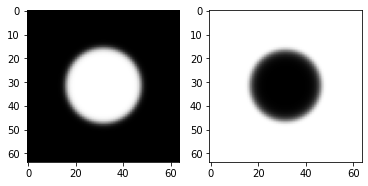

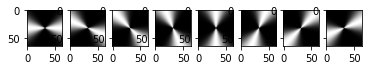

In [ ]:
x = np.linspace(0,1,100)
def logistic(x,centerX,slope):
  y = 1 / (1 + np.exp(-slope*(x-centerX)))
  return(y)

lowPass = 1-logistic(x,0.5,50)
hiPass = np.sqrt(1-lowPass**2)
plt.plot(x,lowPass);
plt.plot(x,hiPass);

def makePyramidFilters(n,k):
  # create a mesh of x, y points
  x,y,extents = getMeshPoints(n);
  # convert into radial coordinates
  r = np.sqrt(x**2+y**2)
  theta = np.arctan2(y,x)
  
  # use a sigmoidal function for the low pass filter
  # note that this is not identical to what is 
  # in the Simoncelli & Freeman paper, as they
  # only specify what the characteristics of the
  # filters should be like (that they should strictly
  # block out frequencies above the cutoff, they
  # should sum-of-squares to 1 and be recursive,
  # but they don't actually derive a form for the
  # filters - just say that they can approximate
  # with a least-squares approximation. So,
  # here we are using a logistic function with
  # a very steep slope. 
  lowPassFilter = 1-logistic(r,0.5,50)
  hiPassFilter = np.sqrt(1-lowPassFilter**2)
  
  # ok, now make the orientation filters
  orientationFilters = []
  for iFilter in range(0,k):
    # set orientation preference
    orientationPreference = iFilter*np.pi/k
    # the orientation filter is just the a sinusoidal function raised to a power of k-1
    orientationFilters.append(np.abs(np.cos(theta-orientationPreference)**(k-1)))

  # return the filters
  return lowPassFilter, hiPassFilter, orientationFilters

k = 8
n = 64
lowPassFilter, hiPassFilter, orientationFilters = makePyramidFilters(n,k)

plt.subplot(1,2,1)
plt.imshow(lowPassFilter,cmap='gray')
plt.subplot(1,2,2)
plt.imshow(hiPassFilter,cmap='gray')
plt.figure()
for iFig in range(0,k):
  plt.subplot(1,k,iFig+1)
  plt.imshow(orientationFilters[iFig],cmap='gray')

#yowsa = np.sqrt(orientationFilters[0]**2 + orientationFilters[1]**2 + orientationFilters[2]**2);
#print(np.max(yowsa))
#print(np.min(yowsa))

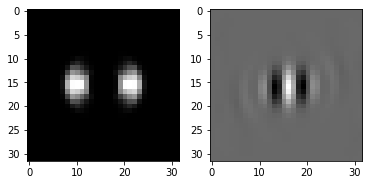

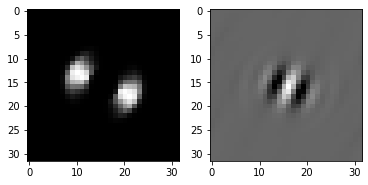

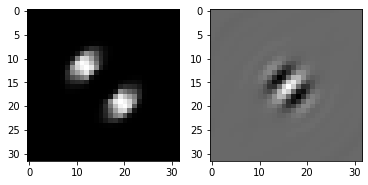

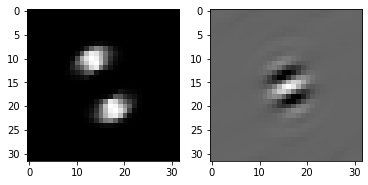

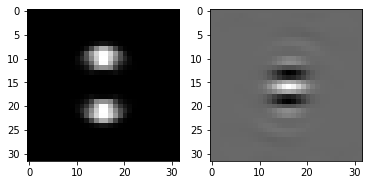

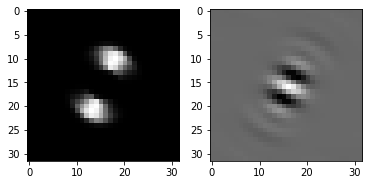

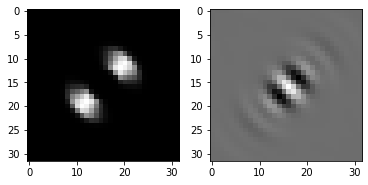

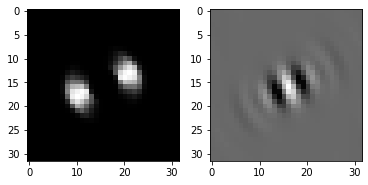

In [ ]:
k = 8
n = 32
lowPassFilter, hiPassFilter, orientationFilters = makePyramidFilters(n,k)
lowPassFilter2, hiPassFilter2, orientationFilters2 = makePyramidFilters(int(n/2),k)

bandPassFilter = upSample(downSample(lowPassFilter))
filter = bandPassFilter
bandPassFilter = lowPassFilter

negBound = int(np.floor(n/2-n/4))
posBound = int(np.ceil(n/2+n/4))
bandPassFilter[negBound:posBound,negBound:posBound] = bandPassFilter[negBound:posBound,negBound:posBound]*hiPassFilter2

# make an image filter out of one of the above
filter = bandPassFilter * orientationFilters[0]
mysave('b.png',filter)
convFilter = np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(filter))))
mysave('c.png',convFilter)

for iFilter in range(0,k):
  filter = bandPassFilter * orientationFilters[iFilter]
  plt.figure()
  plt.subplot(1,2,1)
  plt.imshow(filter,cmap='gray')

  convFilter = np.real(np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(filter))))

  plt.subplot(1,2,2)
  plt.imshow(convFilter,cmap='gray')


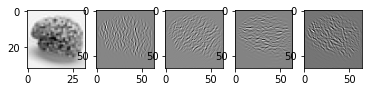

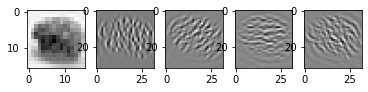

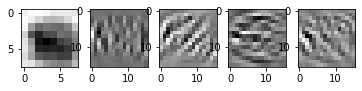

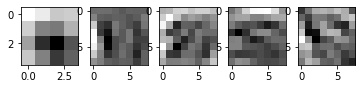

In [ ]:

# get pyramid output for one layer of the pyramid
def pyramidEncode(img,k):
  # get size of image
  n = np.size(img,1)
  
  # get the filters
  lowPassFilter, hiPassFilter, orientationFilters = makePyramidFilters(n,k)

  # split into a low pass and a high pass filter
  # first take transform of image
  imgFFT = np.fft.fftshift(np.fft.fft2(img))
  
  # apply the low pass and high pass filters
  hiPassFilteredImgFFT = imgFFT * hiPassFilter
  lowPassFilteredImgFFT = imgFFT * lowPassFilter
  
  # apply the orientation filters to the hi pass image and take the inverse transform
  orientationAndHiPassFilteredImg = []
  for iFilter in range(0,k):
    # filter
    orientationAndHiPassFilteredImgFFT = hiPassFilteredImgFFT * orientationFilters[iFilter]
    #orientationAndHiPassFilteredImgFFT = hiPassFilteredImgFFT
    # and take the inverse transfrom
    orientationAndHiPassFilteredImg.append(np.real(np.fft.ifft2(np.fft.fftshift(orientationAndHiPassFilteredImgFFT))))
  
  # now downsample and take the inverse transform of the low pass image
  lowPassFilteredImg = np.real(np.fft.ifft2(np.fft.fftshift(lowPassFilteredImgFFT)))
  lowPassFilteredImg = downSample(lowPassFilteredImg)

  # return
  return lowPassFilteredImg, orientationAndHiPassFilteredImg

# try with a disck image
n = 64
diskImage = np.zeros((n,n))  
x,y,extents = getMeshPoints(n)
r = np.sqrt(x**2+y**2)
diskImage[r<0.5] = 1

k = 4
l = 4

#mysave('original.png',img)
def mysave(saveName,img):
  saveImage = (img-np.min(img))/(np.max(img)-np.min(img))
  saveImage = np.repeat(saveImage[:, :, np.newaxis], 3, axis=2)
  image.imsave(saveName,saveImage)

currentImg = img;
for iLevel in range(0,l):
  # filter with the current layer and
  # use the low Pass image as the next level
  currentImg, orientationAndHiPassFilteredImg = pyramidEncode(currentImg,k)

  plt.figure()
  plt.subplot(1,k+1,1)
  plt.imshow(currentImg,cmap='gray')
  mysave("Level%02iLow.png"%(iLevel),currentImg)
  for iPlot in range(0,k):
    plt.subplot(1,k+1,iPlot+2)
    plt.imshow(orientationAndHiPassFilteredImg[iPlot],cmap='gray')
    mysave("Level%02iOrientation%02i.png"%(iLevel,iPlot),orientationAndHiPassFilteredImg[iPlot])
  


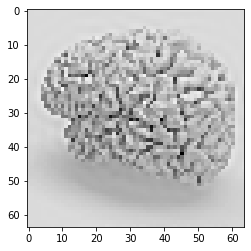

In [ ]:
# take pyramid output for one layer and reconstruct an image
def pyramidDecode(lowPassFilteredImg, orientationAndHiPassFilteredImg):
  # up sample the low Pass Filtered Image
  img = upSample(lowPassFilteredImg)

  # and the high pass orientation filtered images
  k = len(orientationAndHiPassFilteredImg)
  for iFilter in range(0,k):
    img = img + orientationAndHiPassFilteredImg[iFilter]

  return img

k = 4
lowPassFilteredImg, orientationAndHiPassFilteredImg = pyramidEncode(img,k)
reconstructedImg = pyramidDecode(lowPassFilteredImg,orientationAndHiPassFilteredImg)
plt.imshow(reconstructedImg,cmap='gray')


Ok. Now let's see if we can filter the FFT spectrum of our image and get a low-pass image of it.

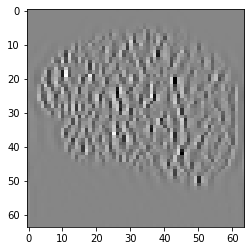

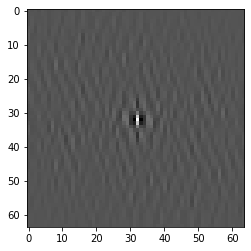

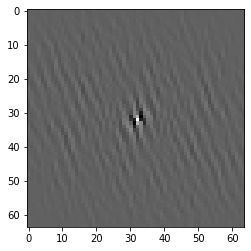

In [ ]:
k=4
lowPassImg, orientationAndHiPassFilteredImg = pyramidEncode(img,k)

o1 = 0;
o2 = 3;
autoCorrelation = signal.correlate(orientationAndHiPassFilteredImg[o1],orientationAndHiPassFilteredImg[o1],mode='same')
crossCorrelation = signal.correlate(orientationAndHiPassFilteredImg[o1],orientationAndHiPassFilteredImg[o2],mode='same')

mysave('o1.png',orientationAndHiPassFilteredImg[o1])
mysave('o2.png',orientationAndHiPassFilteredImg[o2])
mysave('o1o1.png',autoCorrelation)
mysave('o1o2.png',crossCorrelation)

# plot image
plt.figure()
plt.imshow(orientationAndHiPassFilteredImg[0],cmap='gray')
plt.figure()
plt.imshow(autoCorrelation,cmap='gray')
plt.figure()
plt.imshow(crossCorrelation,cmap='gray')

(0.0, 180.0)

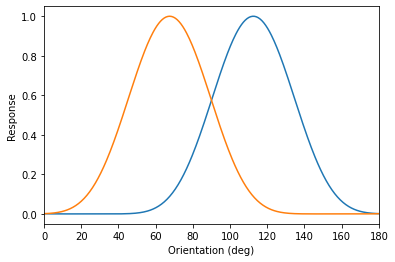

In [ ]:
k = 8
x = np.linspace(0,np.pi*2,720)
offset = (np.pi/2)-(np.pi/8)
plt.plot(x*180/np.pi,np.abs(np.cos(x+offset)**(k-1)))
plt.plot(x*180/np.pi,np.abs(np.cos(x+offset+np.pi/4)**(k-1)))
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,180)

[0.70710678 0.70710678]


(0.0, 360.0)

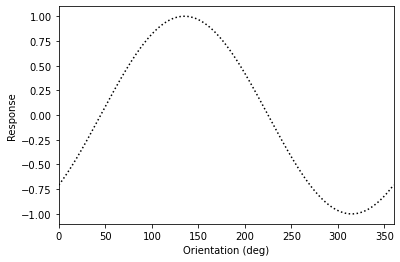

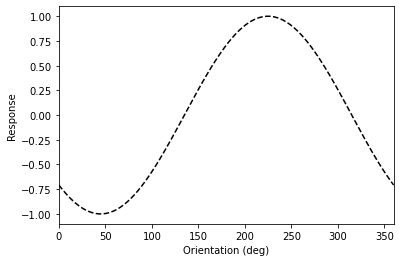

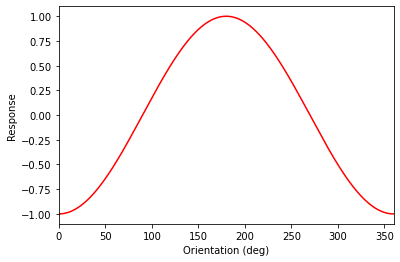

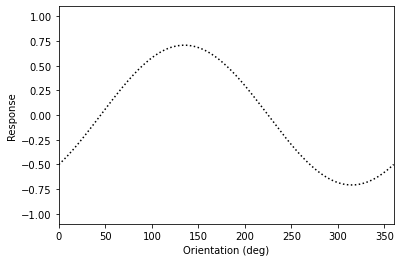

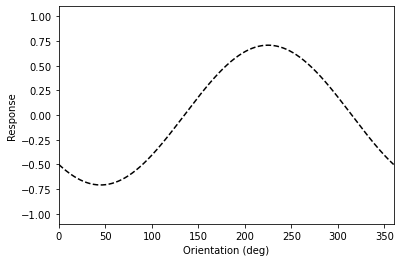

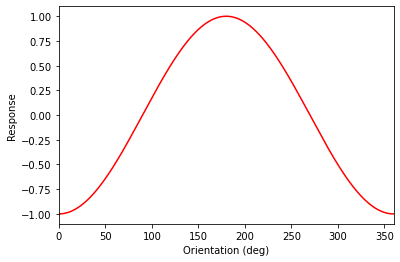

In [ ]:
k = 2
x = np.linspace(0,np.pi*2,720)
offset = (np.pi/8)+5*np.pi/8
basis1 = np.cos(x+offset+np.pi/2)**(k-1)
basis2 = np.cos(x+offset)**(k-1)

#desired phase
phase = np.pi
desired = np.cos(x+phase)**(k-1)
basis = np.vstack((basis1,basis2)).T

fitVals = np.dot((np.dot(np.linalg.inv(np.dot(basis.T,basis)),basis.T)),desired)
print(fitVals)

plt.figure()
plt.plot(x*180/np.pi,basis1,color='k',linestyle=':')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
plt.savefig('sin1.pdf')

plt.figure()
plt.plot(x*180/np.pi,basis2,color='k',linestyle='--')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
plt.savefig('sin2.pdf')

plt.figure()
plt.plot(x*180/np.pi,desired,color='r',linestyle='-')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
plt.savefig('sin2.pdf')


plt.figure()
plt.plot(x*180/np.pi,basis1*fitVals[0],color='k',linestyle=':')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
plt.ylim(-1.1,1.1)
plt.savefig('sin4.pdf')

plt.figure()
plt.plot(x*180/np.pi,basis2*fitVals[1],color='k',linestyle='--')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
plt.ylim(-1.1,1.1)
plt.savefig('sin5.pdf')

plt.figure()
plt.plot(x*180/np.pi,basis1*fitVals[0]+basis2*fitVals[1],color='r',linestyle='-')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
plt.savefig('sin6.pdf')


plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)


[-0.32762991  0.58845562  0.73917429]


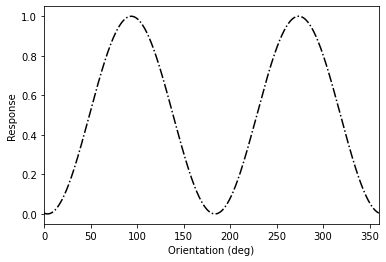

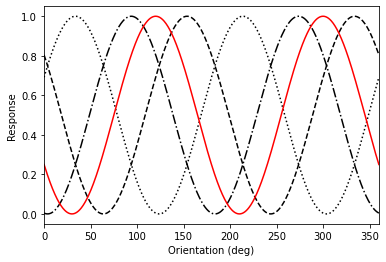

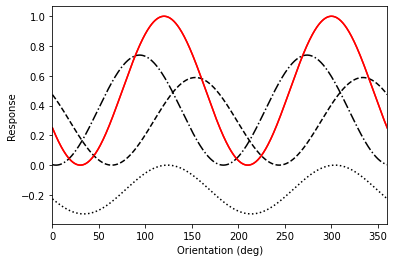

In [ ]:
k = 3
x = np.linspace(0,np.pi*2,720)
offset = (np.pi/8)+5*np.pi/8+ np.pi/16
basis1 = np.cos(x+offset)**(k-1)
basis2 = np.cos(x+offset+np.pi/3)**(k-1)
basis3 = np.cos(x+offset+2*np.pi/3)**(k-1)

#desired phase
phase = np.pi/3
desired = np.cos(x+phase)**(k-1)
basis = np.vstack((basis1,basis2,basis3)).T

fitVals = np.dot((np.dot(np.linalg.inv(np.dot(basis.T,basis)),basis.T)),desired)
print(fitVals)

plt.figure()
plt.plot(x*180/np.pi,basis3,color='k',linestyle='-.')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
plt.savefig('sin1.pdf')

plt.figure()
plt.plot(x*180/np.pi,basis1,color='k',linestyle=':')
plt.plot(x*180/np.pi,basis2,color='k',linestyle='--')
plt.plot(x*180/np.pi,basis3,color='k',linestyle='-.')
plt.plot(x*180/np.pi,desired,color='r',linestyle='-')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)

plt.savefig('sin2.pdf')


plt.figure()
plt.plot(x*180/np.pi,desired,color='r',linestyle='-')
plt.plot(x*180/np.pi,basis1*fitVals[0],color='k',linestyle=':')
plt.plot(x*180/np.pi,basis2*fitVals[1],color='k',linestyle='--')
plt.plot(x*180/np.pi,basis3*fitVals[2],color='k',linestyle='-.')
plt.plot(x*180/np.pi,basis1*fitVals[0]+basis2*fitVals[1]+basis3*fitVals[2],color='r',linestyle='-')
plt.xlabel('Orientation (deg)')
plt.ylabel('Response')
plt.xlim(0,360)
#plt.ylim(-1.1,1.1)
plt.savefig('sin5.pdf')


skew: -0.920
kurtosis: 0.635


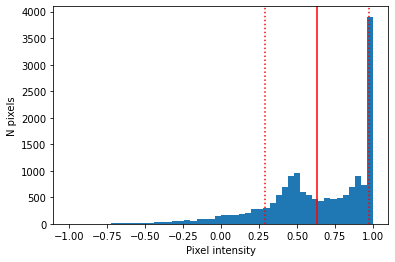

In [ ]:

pixelVals = img.flatten()
meanPixel = np.mean(pixelVals)
stdPixel = np.std(pixelVals)
plt.hist(pixelVals,50);
plt.axvline(np.mean(pixelVals),color='r')
plt.axvline(np.mean(pixelVals)-stdPixel,color='r',linestyle=':')
plt.axvline(np.mean(pixelVals)+stdPixel,color='r',linestyle=':')
plt.xlabel('Pixel intensity')
plt.ylabel('N pixels')
print('skew: %0.3f'%(stats.skew(pixelVals)))
print('kurtosis: %0.3f'%(stats.kurtosis(pixelVals)))
plt.savefig('dist.pdf')

-0.2683044631457786


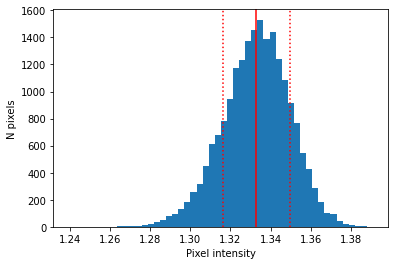

In [ ]:

pixelVals = np.random.normal(loc=10,scale=1,size=20000)**(1/8)
#pixelVals = np.random.normal(loc=10,scale=1,size=20000)
meanPixel = np.mean(pixelVals)
stdPixel = np.std(pixelVals)
plt.hist(pixelVals,50);
plt.axvline(np.mean(pixelVals),color='r')
plt.axvline(np.mean(pixelVals)-stdPixel,color='r',linestyle=':')
plt.axvline(np.mean(pixelVals)+stdPixel,color='r',linestyle=':')

print(stats.skew(pixelVals))
plt.xlabel('Pixel intensity')
plt.ylabel('N pixels')
plt.savefig('pixelstats.pdf')


[-0.04363795]


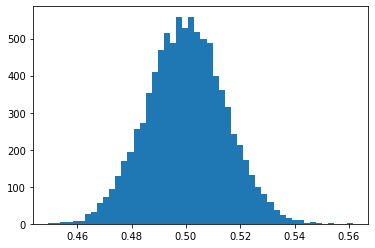

In [ ]:
def densityFun(x):
  # take range of 0 to 1 to 0 to pi
  x = x*np.pi
  p = np.cos(x+np.pi/2)**500
  p = p
  return p
x = np.random.uniform(low=0.4,high=0.6,size=1000)
#plt.plot(x,densityFun(x),'k.')
pixelVals = np.random.normal(loc=10,scale=1,size=20000)**(1/8)
pixelVals = []
for iVal in range(0,50000):
  newVal = np.random.uniform(low=0.4,high=0.6,size=1)
  if densityFun(newVal) > np.random.uniform():
    pixelVals.append(newVal)
  # get probability of value
  
pixelVals = np.array(pixelVals)
meanPixel = np.mean(pixelVals)
stdPixel = np.std(pixelVals)
plt.hist(pixelVals,50);
#plt.axvline(np.mean(pixelVals),color='r')
#plt.axvline(np.mean(pixelVals)-stdPixel,color='r',linestyle=':')
#plt.axvline(np.mean(pixelVals)+stdPixel,color='r',linestyle=':')

print(stats.kurtosis(pixelVals))
#lt.xlabel('Pixel intensity')
#plt.ylabel('N pixels')
#plt.savefig('pixelstats.pdf')
